# Titanic Dataset  - ML Classification Model

## Intro

Poniższe opracowanie wykonano w oparciu o jeden z najpopularniejszych zbiorów danych dostępnych na platformie _kaggle.com_. Dotyczy on katastrofy Titanica i zawiera informacje nt. poszczególnych pasażerów, tj. m.in. tego czy dany pasażer przeżył katastrofę, jaką klasą podróżował, skąd wyruszył itp. Na jego podstawie przygotowano model uczenia maszynowego, który dokonuje klasyfikacji pasażerów na dwie grupy:

- pasażer przeżył katastrofę (1)
- pasażer nie przeżył katastrofy (0)

Jest to przykład uczenia nadzorowanego (ang. supervised learning). Pierwotny zbiór danych jest podzielony na dwa podzbiory: 
- treningowy - użyto go do wytrenowania oraz walidacji modelu
- testowy - użyto go do wykonania prognozy 

#### Kolumny zbioru danych:

    Survived  -  Survival (0 = No, 1 = Yes)
    Pclass  -  Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
    Name - name, surename, title
    Sex  -  gender
    Age  -  Age in years
    SibSp  -  Number of siblings / spouses aboard the Titanic
    Parch  -  Number of parents / children aboard the Titanic
    Ticket  -  Ticket number
    Fare  -  Passenger fare (price)
    Cabin  -  Cabin number
    Embarked  -  Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

#### Etapy projektu:
1. Environment Configuration - konfiguracja środowiska projektu

2. Data Exploration - analiza struktury danych, wizualizacja, próba znalezienia korelacji

3. Feature Engineering & Data Cleaning - preprocessing zbioru treningowego (dobór cech dla modelu, standaryzacja, normalizacja, usunięcie braków danych itp.)

4. Model Building: K-Fold Cross Validation - budowa modelu ML w oparciu o algorytmy klasyfikacyjne oraz walidację krzyżową; ocena jakości modeli

5. Parameters tuning - dobór hiperparametrów modeli w celu zwiększenia jakości

6. Insights From Models - wnioski nt uzyskanych wyników

7. Test Dataset Prediction - prognoza dla testowego zbioru danych

8. Results - eksport wyników, zapis modeli

## 1. Environment Configuration

In [1]:
# Moduły podstawowe
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ustawienia wyświetlania
pd.set_option('display.max_columns', 50)
pd.set_option('precision', 2)
%matplotlib inline

## 2. Data Exploration
#### Ładowanie danych do DataFrame:

Zbiór treningowy zostanie wykorzystany do uczenia modeli oraz ich walidacji. 
Zbiór testowy zostanie wykorzystany do uzyskania prognoz za pomocą utworzonych modeli.

In [3]:
# zbiór treningowy
X_full = pd.read_csv('./Titanic_dataset/train.csv', index_col='PassengerId')

# zbiór testowy
X_test_full = pd.read_csv('./Titanic_dataset/test.csv', index_col='PassengerId')

#### Rzut oka na strukturę danych:

In [4]:
X_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [5]:
print(X_full.shape)
X_full.info()

(891, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Zbiór treningowy składa się z 891 obserwacji i 11 atrybutów, co oznacza, że jest on bardzo mały jak na standardy uczenia maszynowego. Wyraźnie widać, że atrybut _Cabin_ zawiera jedynie 204 wartości niezerowe, co oznacza, że cecha ta nie została zdefiniowana dla blisko 80% obserwacji. Braki danych zawierają ponadto atrybuty _Age_ i _Embarked_, ale nie są one tak znaczące.

W związku z powyższym od razu zdecydowano się usunąć kolumnę _Cabin_ ze zbioru treningowego.

In [6]:
# Usunięcie kolumny "Cabin" ze względu na przeważającą ilość braków danych
X_full.drop(columns=['Cabin'], inplace=True)

In [7]:
X_full.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


#### Podział danych na numeryczne i kategoryczne:

In [8]:
data_num = X_full[['Age', 'SibSp', 'Parch', 'Fare']]
data_cat = X_full[['Survived', 'Pclass', 'Sex', 'Ticket', 'Embarked']]

#### Wizualizacja danych
#### - Dane numeryczne:

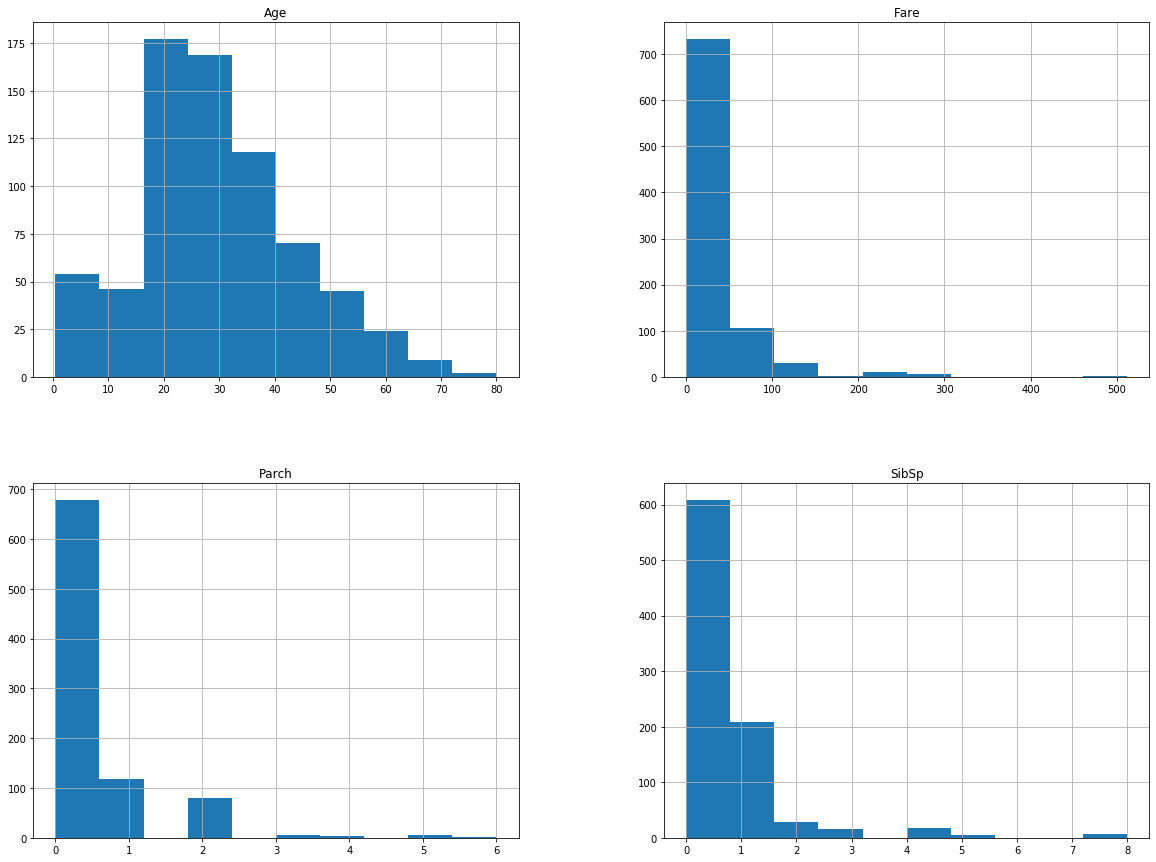

In [9]:
# histogramy (rozkład ilościowy) danych numerycznych
data_num.hist(figsize=(20,15))
plt.show()

Analizując powyższe rozkłady danych numerycznych widać, że jedynie atrybut _Age_ posiada rozkład zbliżony do rozkładu normalnego. Dla pozostałych atrybutów konieczna będzie ich modyfikacja, np. poprzez zastosowanie normalizacji.

In [10]:
# korelacje pomiędzy zmiennymi
correlation = data_num.corr()
correlation

,Age,SibSp,Parch,Fare
Age,1.00,-0.31,-0.19,0.10
SibSp,-0.31,1.00,0.41,0.16
Parch,-0.19,0.41,1.00,0.22
Fare,0.10,0.16,0.22,1.00


In [ ]:
sns.heatmap(correlation)

Atrybuty numeryczne są ze sobą raczej słabo skorelowane. Najsilniejsza korelacja występuje pomiędzy atrybutami _SibSp_ i _Parch_ , które dotyczą ilości członków rodziny pasażerów na pokładzie.

In [11]:
# Średnia zmiennych numerycznych w zależności od wskaźnika przeżywalności
pd.pivot_table(X_full, index='Survived', values=data_num.columns)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.63,22.12,0.33,0.55
1,28.34,48.40,0.46,0.47


#### - Dane kategoryczne:

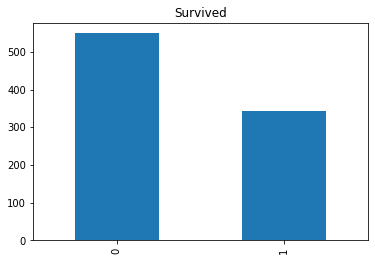

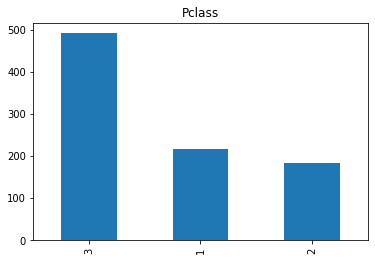

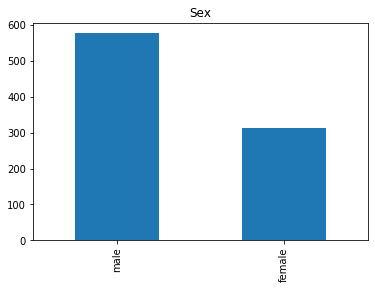

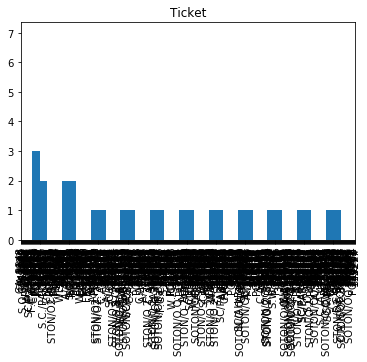

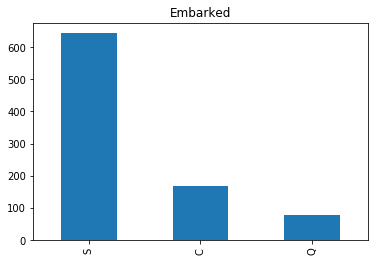

In [12]:
# Podział ilościowy dla każdej z wartości danych kategorycznych
for c in data_cat.columns:
    data_cat[c].value_counts().plot(kind="bar")
    plt.title(c)
    plt.show()

Blisko 2/3 pasażerów znajdujących się na pokładzie nie przeżyło katastrofy. Ponad połowa z nich podróżowała klasą 3. Zdecydowaną większość stanowili mężczyźni, którzy rozpoczęli swoją podróż w porcie w Southampton.

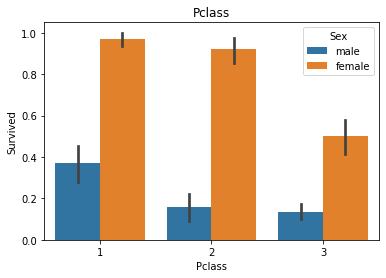

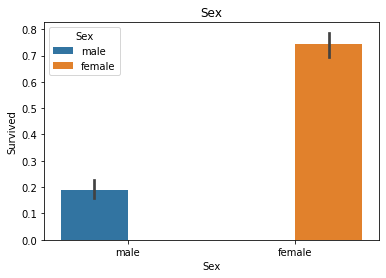

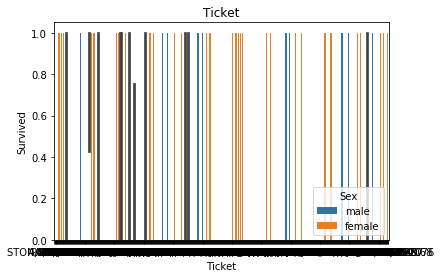

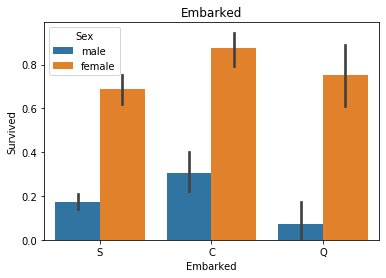

In [13]:
# Przeżywalność pasażerów w zależności wartości zmiennych kategorycznych z podziałem na płeć
for c in data_cat.columns[1:]:
    sns.barplot(x=c, y='Survived', hue='Sex', data=data_cat)
    plt.title(c)
    plt.show()

Analizując dane pod kątem przeżywalności wyraźnie widać, że grupą wyraźnie dominującą niezależnie od kryterium podziału jest płeć żeńska. Bierze się to z faktu, że kobiety i dzieci miały pierwszeństwo podczas opuszczania statku. Na tę chwilę można założyć, iż płeć będzie cechą determinującą wartość przewidywań niezależnie od rodzaju modelu ML.

## 3. Feature Engineering & Data Cleaning

Preprocessing zbioru treningowego pod kątem modeli ML.

#### Treningowy zbiór danych (X_full):

In [14]:
# Utworzono kolumnę 'Ticket_category' dzielącą bilety na trzy kategorie:
# - 0 - jeśli symbol biletu składa się z samych liter
# - 1 - jeśli z samych cyfr
# - 2 - jeśli z cyfr i liter
X_full['Ticket_category'] = X_full['Ticket'].apply(
    lambda x: 1 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isdigit() else 
    2 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isalnum() else 0)

# Liczba ocalałych w zależności od kategorii biletu
pd.pivot_table(X_full, index='Survived', columns='Ticket_category', values='Ticket', aggfunc='count')

Ticket_category,1,2
Survived,,
0,407,142
1,254,88


In [15]:
# Usunięto zbędną kolumnę 'Ticket'
X_full.drop(columns=['Ticket'], inplace=True)

In [16]:
# Wyodrębniono tytuł pasażera na podstawie kolumny 'Name'
X_full['Name_title'] = X_full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# COUNT ENCODING
# Zakodowano tytuł pasażera zastępując go liczbą wystąpień danego tytułu w zbiorze danych
import category_encoders as ce
count_enc = ce.CountEncoder() # uwtorzono Count Encoder

# Zmodyfikowano cechę 'Name_title'; zmieniono nazwę kolumny dodając suffix '_count' i dołączono ją do DF
count_encoded = count_enc.fit_transform(X_full['Name_title'])
X_full = X_full.join(count_encoded.add_suffix("_count"))

# Usunięto zbędne kolumny: Name, Name_title
X_full.drop(columns=['Name', 'Name_title'], inplace=True)

In [17]:
# ONE HOT ENCODING (OHE)
# Zakodowano pozostałe kolumny kategoryczne (Sex i Embarked) za pomocą One Hot Encoding
object_cols = [col for col in X_full.columns if X_full[col].dtype == "object"] # Kolumny kategoryczne

# Kolumna 'Embarked' zawiera 2 brakujące wartości -> usunięto te 2 wiersze
X_full.dropna(subset=['Embarked'], how='any', inplace=True)

from sklearn.preprocessing import OneHotEncoder

# OHE dla każdej kolumny kategorycznej
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_full[object_cols]))

# Przywrócenie indeksów wyrzuconych automatycznie przez OHE
OH_cols_train.index = X_full.index

# Dodanie kolumn powstałych z OHE do zbioru treningowego (X_full)
X_full = pd.concat([X_full, OH_cols_train], axis=1)

# Usunięcie pierwotnych kolumn kategorycznych ze zbioru treningowego
X_full.drop(columns=object_cols, inplace=True)

In [18]:
# Modyfikacja kolumny 'Fare' poprzez normalizację do rozkładu normalnego
X_full['Fare_normal'] = np.log(X_full['Fare'])

# Usunięcie zbędnej kolumnę 'Fare'
X_full.drop(columns=['Fare'], inplace=True)

C:\Users\Maciek\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
# Zastąpienie braków w kolumnie 'Age' medianą:
X_full['Age'] = X_full['Age'].fillna(X_full['Age'].median())

In [20]:
# Standaryzacja cech: Age, SibSp, Parch, Name_title_count
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_full[['Age', 'SibSp', 'Parch', 'Name_title_count']] = scale.fit_transform(
    X_full[['Age', 'SibSp', 'Parch', 'Name_title_count']])

##### Test dataset (X_test_full):

In [21]:
# Usunięcie kolumny "Cabin"
X_test_full.drop(columns=['Cabin'], inplace=True)

# Utworzono kolumnę 'Ticket_category' dzielącą bilety na trzy kategorie
X_test_full['Ticket_category'] = X_test_full['Ticket'].apply(
    lambda x: 1 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isdigit() else 
    2 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isalnum() else 0)

# Usunięto zbędną kolumnę 'Ticket'
X_test_full.drop(columns=['Ticket'], inplace=True)

# Wyodrębniono tytuł pasażera na podstawie kolumny 'Name'
X_test_full['Name_title'] = X_test_full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# COUNT ENCODING
# Zakodowano tytuł pasażera zastępując go liczbą wystąpień danego tytułu w zbiorze danych
count_enc = ce.CountEncoder() # tworzymy Count Encoder

# Zmodyfikowano cechę 'Name_title'; Zmieniono nazwę kolumny dodając suffix '_count' i dołączono ją do DF
count_encoded = count_enc.fit_transform(X_test_full['Name_title'])
X_test_full = X_test_full.join(count_encoded.add_suffix("_count"))

# Usunięto zbędne kolumny: Name, Name_title
X_test_full.drop(columns=['Name', 'Name_title'], inplace=True)

# ONE HOT ENCODING
# Zakodowano pozostałe kolumny kategoryczne (Sex i Embarked) za pomocą One Hot Encoding
object_cols = [col for col in X_test_full.columns if X_test_full[col].dtype == "object"] # Kolumny kategoryczne

# Kolumna 'Embarked' zawiera 2 brakujące wartości -> usunięto te 2 wiersze
X_test_full.dropna(subset=['Embarked'], how='any', inplace=True)

from sklearn.preprocessing import OneHotEncoder

# OHE dla każdej kolumny kategorycznej
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_test_full[object_cols]))

# Przywrócenie indeksów wyrzuconych automatycznie przez OHE
OH_cols_train.index = X_test_full.index

# Dodanie kolumn powstałych z OHE do zbioru treningowego (X_full)
X_test_full = pd.concat([X_test_full, OH_cols_train], axis=1)

# Usunięcie pierwotnych kolumn kategorycznych ze zbioru treningowego
X_test_full.drop(columns=object_cols, inplace=True)

# Modyfikacja kolumny 'Fare' poprzez normalizację do rozkładu normalnego
X_test_full['Fare_normal'] = np.log(X_test_full['Fare'])

# Usuwnięcie zbędną kolumnę 'Fare'
X_test_full.drop(columns=['Fare'], inplace=True)

# Zastąpienie braków w kolumnie 'Age' medianą:
X_test_full['Age'] = X_test_full['Age'].fillna(X_test_full['Age'].median())

# Standaryzacja cech: Age, SibSp, Parch, Name_title_count
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_test_full[['Age', 'SibSp', 'Parch', 'Name_title_count']] = scale.fit_transform(
    X_test_full[['Age', 'SibSp', 'Parch', 'Name_title_count']])

C:\Users\Maciek\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 4. Model building: K-Fold Cross Validation

In [22]:
X_train = X_full.drop(columns=['Survived'])
y_train = X_full['Survived']

In [23]:
# Moduł Sklearn dokonuje "w tle" konwersji typów danych na 'float32' co może być źródłem problemów, ponieważ czasem ma 
# miejsce konwersja na wartości nieskończone (infinite values), które nasz model traktuje jak NaN. W celu uniknięcia
# związanych z tym błędów (ValueError) dokonano konwersji ręcznej na typ 'float32' a następnie zastąpiono wszystkie możliwe
# NaN przez wartość 0 (ustawienie domyślne) oraz wszystkie wartości "infinite" przez największą możliwą skończoną wartość 
# zmiennoprzecinkową (largest finite floating point value) dla typu 'float32'

X_train = np.nan_to_num(X_train.astype(np.float32))
y_train = np.nan_to_num(y_train.astype(np.float32))

In [24]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Modele o domyślnych ustawieniach parametrów
model_1 = DecisionTreeClassifier(random_state=1)
model_2 = RandomForestClassifier(random_state=1)
model_3 = KNeighborsClassifier()
model_4 = SVC(probability=True)

models = [model_1, model_2, model_3, model_4]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Ocena jakości modeli
cv_1 = cross_val_score(model_1, X_train, y_train, cv=kf)
cv_2 = cross_val_score(model_2, X_train, y_train, cv=kf)
cv_3 = cross_val_score(model_3, X_train, y_train, cv=kf)
cv_4 = cross_val_score(model_4, X_train, y_train, cv=kf)

print("Model_1: ", cv_1.mean())
print("Model_2: ", cv_2.mean())
print("Model_3: ", cv_3.mean())
print("Model_4: ", cv_4.mean())

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

Model_1:  0.7862756300387229
Model_2:  0.8121119786707294
Model_3:  0.7997587761061385
Model_4:  0.8233860217101505


#### Wnioski:

Dla domyślnych parametrów modeli najlepszą jakość przewidywań uzyskał model oparty na algorytmie SVC ( _Support Vector Classifier_ ).

## 5. Parameters Tuning

Poprawa wydajności powyższych modeli poprzez dostrojenie ich parametrów.

In [26]:
from sklearn.model_selection import GridSearchCV

# DECISION TREE CLASSIFIER (model_1)
# określenie możliwych wartości hiperparametrów
params_model_1 = {"criterion": ["gini", "entropy"], 
                  "max_leaf_nodes": [5, 50, 100, 200],
                  "splitter": ["best", "random"],
                  "max_depth": [3, 5, 7, 10],
                  "min_samples_split": [2, 4, 6, 8]}

gridsearch_model_1 = GridSearchCV(model_1, param_grid=params_model_1, cv=kf, verbose=0)

# Zagnieżdżony sprawdzian krzyżowy dla sprawdzenia jakości najlepszego modelu
quality_model_1 = cross_val_score(gridsearch_model_1, X_train, y_train).mean()
print(quality_model_1)

# Wydobycie parametrów dla najlepszego modelu
best_model_1 = gridsearch_model_1.fit(X_train, y_train)
best_model_1.best_estimator_.get_params()

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8031857615190949


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 50,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 1,
 'splitter': 'best'}

#### Wniosek:

Po dostrojeniu wybranych parametrów jakość przewidywań modelu opartego o algorytm Drzew Decyzyjnych (model_1) **wzrosła** z _0.7863_ do _0.8032_.

In [33]:
# RANDOM FOREST CLASSIFIER (model_2)
params_model_2 = {"n_estimators": [100, 200],
                 "max_depth": [5, 6],
                 "criterion": ["gini", "entropy"]}

gridsearch_model_2 = GridSearchCV(model_2, param_grid=params_model_2, cv=kf, verbose=0, n_jobs=-1)

# Zagnieżdżony sprawdzian krzyżowy dla sprawdzenia jakości najlepszego modelu
quality_model_2 = cross_val_score(gridsearch_model_2, X_train, y_train).mean()
print(quality_model_2)

# Wydobycie parametrów dla najlepszego modelu
best_model_2 = gridsearch_model_2.fit(X_train, y_train)
best_model_2.best_estimator_.get_params()

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8245328661995329


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

#### Wniosek:

Po dostrojeniu wybranych parametrów jakość przewidywań modelu opartego o algorytm Lasów Losowych (model_2) **wzrosła** z _0.8121_ do _0.8245_.

In [29]:
# K-NEIGHBORS CLASSIFIER
params_model_3 = {"n_neighbors": [3, 5, 7, 9],
                  "weights": ["uniform", "distance"],
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

gridsearch_model_3 = GridSearchCV(model_3, param_grid=params_model_3, cv=kf, verbose=0, n_jobs=-1)

# Zagnieżdżony sprawdzian krzyżowy dla sprawdzenia jakości najlepszego modelu
quality_model_3 = cross_val_score(gridsearch_model_3, X_train, y_train).mean()
print(quality_model_3)

# Wydobycie parametrów dla najlepszego modelu
best_model_3 = gridsearch_model_3.fit(X_train, y_train)
best_model_3.best_estimator_.get_params()

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7986736736736737


{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

#### Wniosek:

Co ciekawe, po dostrojeniu wybranych parametrów jakość przewidywań modelu opartego o algorytm K-Najbliższych Sąsiadów (model_3) **nieznacznie spadła** z _0.7998_ do _0.7987_.

In [31]:
# SVC
params_model_4 = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
                  "gamma": ["scale", "auto"]}

gridsearch_model_4 = GridSearchCV(model_4, param_grid=params_model_4, cv=kf, verbose=0, n_jobs=-1)

# Zagnieżdżony sprawdzian krzyżowy dla sprawdzenia jakości najlepszego modelu
quality_model_4 = cross_val_score(gridsearch_model_4, X_train, y_train).mean()
print(quality_model_4)

# Wydobycie parametrów dla najlepszego modelu
best_model_4 = gridsearch_model_4.fit(X_train, y_train)
best_model_4.best_estimator_.get_params()

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8245328661995329


{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Wniosek:

Po dostrojeniu wybranych parametrów jakość przewidywań modelu opartego o algorytm SVC (model_4) **nieznacznie wzrosła** z _0.8234_ do _0.8245_.

## 6. Insights From Models

## 7. Test Dataset Prediction

In [ ]:
# trenowanie modelu opartego o który model????????????
final_training = model_4.fit(X_train, y_train)

In [ ]:
# Kopia zbioru testowego oraz pozbycie się potencjalnych wartości nieskończonych
test = X_test_full.copy()
test = np.nan_to_num(test.astype(np.float32))

# Predykcja dla zbioru testowego
test_preds = final_training.predict(test).astype(int)

# Przywrócenie zbioru 'test' do postaci DF
test = pd.DataFrame(test, index=X_test_full.index, columns=X_test_full.columns)

# Utworzenie DF dla wyników przewidywań
results = {'PassengerId': test.index, 'Survived': test_preds}
results = pd.DataFrame(data=results)
results.head()

## 8. Results